In [1000]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [1001]:
tracks_t = uproot.open("../test.root:diffusion output")
tracks_t.values()
def distance_formula(pix0, pix1):
    return (np.sqrt((pix0[0]-pix1[0])**2 + (pix0[1]-pix1[1])**2))

def label_nearby(deps,idx,track_idx):
    #deps is depositions
    #given a track_id, identify all pixels with track_id and then label all pixels touching track_id
    
    found=False
    diff=np.diff(deps[:,2])
    for start_pix in deps[np.argwhere(track_idx==idx)]:
        #print(start_pix)
        i_start=start_pix[0][0]
        j_start=start_pix[0][1]
        z_start=start_pix[0][2]
        
        for i, pixel in enumerate(deps):
            
            i_check=pixel[0]
            j_check=pixel[1]
            z_check=pixel[2]
            
            if (not np.isnan(track_idx[i])):
                continue
            #print(start_pix, pixel, diff[i-1])
            #print(np.abs(z_start-z_check))
            if(np.abs(z_start-z_check)<=4):
                
                dist=np.sqrt((i_check-i_start)**2 + (j_check-j_start)**2)
                if(dist<2):
                    found=True
                    track_idx[i]=idx+1
    if (not found):
        #move on with next nan value
        loc=np.min(np.argwhere(np.isnan(track_idx)))
        track_idx[loc] = idx+1
    return track_idx
def label_track(deps):
    #label all depositions with track ids
    track_idx=np.empty(len(deps))
    track_idx[:]=np.nan
    track_idx[0]=0
    idx=0
    while(np.isnan(np.sum(track_idx))):
        track_idx=label_nearby(deps, idx, track_idx)
        idx+=1
    return track_idx
def average_track(track_ids, deps):
    avg_pixels=[]
    for pix_id in range(int(max(track_ids))):
        locs = (np.argwhere(track_ids==pix_id))
        pixels = deps[locs][:,0]
        x_avg=np.average(pixels[:,0])
        y_avg=np.average(pixels[:,1])
        avg_pixels.append([x_avg,y_avg])
    avg_pixels=np.array(avg_pixels)
    return avg_pixels

In [1002]:
event_num = 0
x_pix = tracks_t["x_pix"].array()[event_num]
y_pix = tracks_t["y_pix"].array()[event_num]
c_dep = tracks_t["depC_pix"].array()[event_num]
z_toa = tracks_t["z_toa"].array()[event_num]
z_toa = z_toa - min(z_toa)

Method: set start pixel idx to 0, set all touching pixels idx to 1 and repeat
then average numbers


124


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
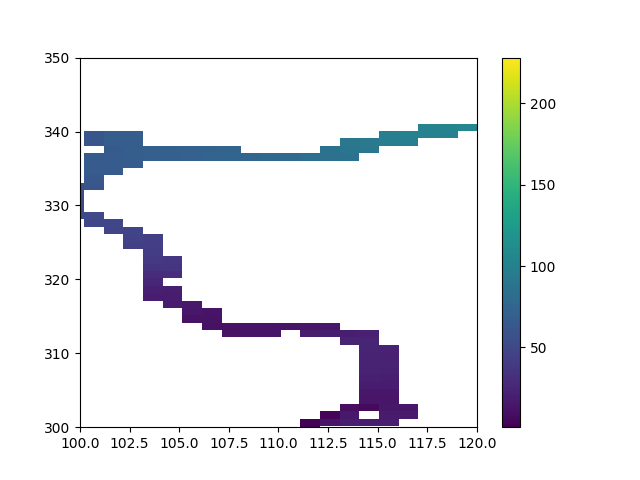

In [1003]:
pix, xedges, yedges, image = plt.hist2d(x_pix, y_pix, (max(x_pix), max(y_pix)), weights=z_toa, cmin=1)
#plt.plot(locs[0],locs[1], 'go')
plt.plot(x_pix[0], y_pix[0],'go')
plt.xlim(100,120)
plt.ylim(300,350)
plt.colorbar()
print(len(pix))

In [1004]:
deps=np.dstack((np.array(x_pix),np.array(y_pix),np.array(z_toa)))[0]
track_idx=np.empty(len(deps))
track_idx[:]=np.nan
track_idx[0]=0
idx=0
track_id=label_track(deps)

In [1005]:
avg_track=average_track(track_id, deps)

In [1007]:
pix, xedges, yedges, image = plt.hist2d(avg_track[:,0], avg_track[:,1], (max(x_pix), max(y_pix)),cmin=1)
plt.xlim(100,120)
plt.ylim(300,350)

(300.0, 350.0)